# Introduction

This notebook demonstrates how to use the Vertex SDK to create video action recognition models using [AutoML](https://cloud.google.com/vertex-ai/docs/start/automl-users).

Specifically, we will be training and evaluating a model that recognizes volleyball serves.


## Objective

In this notebook, we evaluate the AutoML video action recognition model we trained in the first notebook. 

The steps performed include:

- Make a batch prediction.
- View the model evaluation.

## Authenticate Google Cloud account (for local only)



**If we are using Vertex AI Notebooks**, your environment is already authenticated. Skip this step.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

**Click Create service account**.

In the **Service account name** field, enter a name, and click **Create**.

In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex" into the filter box, and select **Vertex Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

Click Create. A JSON file that contains your key downloads to your local environment.

Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [1]:
# This provides access to our Cloud Storage bucket and lets us submit training jobs and prediction
# requests.
import os
import sys

# If on Google Cloud Notebook, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

# <font color='red'>Global Parameters</font>

<font color='red'> This section sets the global parameters for the downstream sections. Always run the cells in this section even if you're only running the later section (e.g. prediction)

### Project ID

In [2]:
PROJECT_ID = "sharp-leaf-344111"  # @param {type:"string"}

In [3]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)
else:
    print("Project ID:", PROJECT_ID)

Project ID: sharp-leaf-344111


In [ ]:
# only run if it is local
! gcloud config set project $PROJECT_ID

### Region

We can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. To start with, we will be using  `europe-west4` as it is the closest to Nagra. The following regions are also available for Vertex AI:

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

Note: we may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services. (learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations))

In [11]:
REGION = "us-central1"  

### GCS bucket

When we initialize the Vertex SDK for Python, we specify a Cloud Storage staging bucket, into which all data associated with our dataset and model resources will be saved. Set the name of our GCS below.

In [4]:
BUCKET_NAME = "gs://aliz_action_recognition_poc"  # @param {type:"string"}

**Only if the bucket doesn't already exist**: Run the following cell to create a new Cloud Storage bucket.

In [5]:
! gsutil mb -l $REGION $BUCKET_NAME

CommandException: Incorrect option(s) specified. Usage:

  gsutil mb [-b (on|off)] [-c <class>] [-k <key>] [-l <location>] [-p <project>]
            [--autoclass] [--retention <time>] [--pap <setting>]
            [--placement <region1>,<region2>]
            [--rpo (ASYNC_TURBO|DEFAULT)] gs://<bucket_name>...

For additional help run:
  gsutil help mb


Validate access to the bucket by examining its contents:

In [6]:
! gsutil ls -al $BUCKET_NAME

 376743798  2022-03-31T17:13:44Z  gs://aliz_action_recognition_poc/Aspire_11_vs_AZ_Sky_11_Gold_2022-02-05.mp4#1648746824256424  metageneration=1
 367656178  2022-03-31T17:13:43Z  gs://aliz_action_recognition_poc/Aspire_15_vs_SG_Elite__2022-02-21.mp4#1648746823872950  metageneration=1
    101022  2022-04-21T14:59:17Z  gs://aliz_action_recognition_poc/Nagra - training.csv#1650553157400516  metageneration=1
 771812506  2022-03-22T07:48:19Z  gs://aliz_action_recognition_poc/RVA_16P_vs_OJVA.mp4#1647935299871660  metageneration=1
     34104  2022-03-23T18:21:05Z  gs://aliz_action_recognition_poc/sample.csv#1648059665898925  metageneration=1
       173  2022-03-31T18:52:01Z  gs://aliz_action_recognition_poc/test.json#1648752721716317  metageneration=1
       117  2022-03-31T18:47:27Z  gs://aliz_action_recognition_poc/test.jsonl#1648752447798314  metageneration=1
       169  2022-04-21T18:59:47Z  gs://aliz_action_recognition_poc/test_1.json#1650567587216084  metageneration=1
       164  2022-0

### Vertex SDK Initialization

Initialize the Vertex SDK for Python for our project and corresponding bucket.

In [37]:
import google.cloud.aiplatform as aiplatform
aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)
import pandas as pd
import numpy as np
import json
from pprint import pprint
from utils import create_upload_test_json, do_batch_prediction, combine_true_pred_label, draw_piechart, get_classification_metrics, pretty_display

# Evaluation 

After our model has finished training, we can retrieve its evaluation metrics.

First, we'll need to get a reference to the new model. We can simply choose the latest model in our project. 

In [12]:
# Get model resource ID
# models = aiplatform.Model.list(filter="display_name=" + disp_name) # alternatively we can directly go to the model
models = aiplatform.Model.list(project=PROJECT_ID)
model = models[0]
print(f"Analyzing model with display name {model.display_name}\n")
# Get a reference to the Model Service client
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
model_service_client = aiplatform.gapic.ModelServiceClient(
    client_options=client_options
)

model_evaluations = list(model_service_client.list_model_evaluations(
    parent=models[0].resource_name
))

model_evaluation = model_evaluations[0]

# The model_evaluation object contains the information related to our model's performance.
print(model_evaluation)

Analyzing model with display name volley_2022/04/21_18:39:27

name: "projects/276875326730/locations/us-central1/models/1523575670423158784/evaluations/1402408114652708864"
metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/video_action_recognition_metrics_1.0.0.yaml"
metrics {
  struct_value {
    fields {
      key: "evaluatedActionCount"
      value {
        number_value: 169.0
      }
    }
    fields {
      key: "videoActionMetrics"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "confidenceMetrics"
                value {
                  list_value {
                    values {
                      struct_value {
                        fields {
                          key: "confidenceThreshold"
                          value {
                            number_value: 0.9999937
                          }
                        }
                        fields {
         

In [13]:
# Examples as to how to get specific metric values
model_evaluation.metrics["videoActionMetrics"][2]["precisionWindowLength"] # the "0" here refers to the different precision window length. 0 = 1s, 1 = 1s, 2 = 2s
model_evaluation.metrics["videoActionMetrics"][2]["confidenceMetrics"][0]["recall"] # choose among 'confidenceThreshold', 'recall', 'f1Score', 'precision'

0.00591716

# Prediction

In this section, we'll perform a batch prediction to using our deployed model.

### Get test item(s)

Now do a batch prediction to your Vertex model.

First, input the list of video(s) on which you'd like to evaluate your model. 

To this end, we'll grab some videos for testing from the import file that we used during training.

In [14]:
import_file_df = pd.read_csv("gs://aliz_action_recognition_poc/training_expanded.csv", header = None)
COLUMNS = ["train_test_split", "gcs_url", "start", "end", "action", "timestamp"]
import_file_df.columns = COLUMNS
import_file_df.head()

,train_test_split,gcs_url,start,end,action,timestamp
0,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,365
1,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,380
2,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,401
3,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,427
4,train,gs://aliz_action_recognition_poc/trunc_video/A...,0,1033,serve,459


In [15]:
test_video_urls = import_file_df.loc[import_file_df["train_test_split"] == "test", "gcs_url"].unique()
test_video_urls

array(['gs://aliz_action_recognition_poc/trunc_video/Rukkus_vs__TVT_2022-01-22.mp4',
       'gs://aliz_action_recognition_poc/trunc_video/MxtuVgTAgnhtsDaqVF1.mp4',
       'gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4',
       'gs://aliz_action_recognition_poc/trunc_video/RVA_15_Elite_v_Saddleback_15.mp4',
       'gs://aliz_action_recognition_poc/trunc_video/Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4',
       'gs://aliz_action_recognition_poc/trunc_video/RVA_13_Black_vs_GVJ_Jessica_2022-01-29.mp4',
       'gs://aliz_action_recognition_poc/trunc_video/RVA_16P_vs_OJVA.mp4'],
      dtype=object)

In [16]:
print("The number of videos:")
print(len(test_video_urls))

The number of videos:
7


### Make a batch input file

Now make a batch input file, which you store in your local Cloud Storage bucket. The batch input file can be either CSV or JSONL. 

We will use JSONL. In the JSONL file, we'll make one dictionary entry per line for each video. The dictionary contains the key/value pairs:

- `content`: The Cloud Storage path to the video.
- `mimeType`: The content type. In our example, it is a `avi` file.
- `timeSegmentStart`: The start timestamp in the video to do prediction on. *Note*, the timestamp must be specified as a string and followed by s (second), m (minute) or h (hour).
- `timeSegmentEnd`: The end timestamp in the video to do prediction on.

The `create_upload_test_json` will facilitate the creation of these json files.

In [17]:
test_json_urls = create_upload_test_json(test_video_urls,
                                        import_file_df = import_file_df,
                                        test_json_folder = "test_json",
                                        bucket_name = "gs://aliz_action_recognition_poc",
                                        time_segment_start = 0)

1. The video 'Rukkus_vs__TVT_2022-01-22.mp4' has been inputted into the test json 'gs://aliz_action_recognition_poc/test_json/pred_Rukkus_vs__TVT_2022-01-22.mp4.json'
2. The video 'MxtuVgTAgnhtsDaqVF1.mp4' has been inputted into the test json 'gs://aliz_action_recognition_poc/test_json/pred_MxtuVgTAgnhtsDaqVF1.mp4.json'
3. The video 'Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4' has been inputted into the test json 'gs://aliz_action_recognition_poc/test_json/pred_Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4.json'
4. The video 'RVA_15_Elite_v_Saddleback_15.mp4' has been inputted into the test json 'gs://aliz_action_recognition_poc/test_json/pred_RVA_15_Elite_v_Saddleback_15.mp4.json'
5. The video 'Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4' has been inputted into the test json 'gs://aliz_action_recognition_poc/test_json/pred_Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4.json'
6. The video 'RVA_13_Black_vs_GVJ_Jessica_2022-01-29.mp4' has been inputted into the test json 'gs://al

### Make the batch prediction request

Now that your Model resource is trained, you can make a batch prediction by invoking the batch_predict() method, with the following parameters:

- `job_display_name`: The human readable name for the batch prediction job.
- `gcs_source`: A list of one or more batch request input files.
- `gcs_destination_prefix`: The Cloud Storage location for storing the batch prediction resuls.
- `sync`: If set to True, the call will block while waiting for the asynchronous batch job to complete.


Note: you can't run too many batch prediction jobs at once or you'll get resource error! Do 3 at a time.

In [18]:
test_json_urls

['gs://aliz_action_recognition_poc/test_json/pred_Rukkus_vs__TVT_2022-01-22.mp4.json',
 'gs://aliz_action_recognition_poc/test_json/pred_MxtuVgTAgnhtsDaqVF1.mp4.json',
 'gs://aliz_action_recognition_poc/test_json/pred_Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4.json',
 'gs://aliz_action_recognition_poc/test_json/pred_RVA_15_Elite_v_Saddleback_15.mp4.json',
 'gs://aliz_action_recognition_poc/test_json/pred_Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4.json',
 'gs://aliz_action_recognition_poc/test_json/pred_RVA_13_Black_vs_GVJ_Jessica_2022-01-29.mp4.json',
 'gs://aliz_action_recognition_poc/test_json/pred_RVA_16P_vs_OJVA.mp4.json']

In [19]:
do_batch_prediction(test_json_urls, model)

Creating prediction job for video 'Rukkus_vs__TVT_2022-01-22.mp4':
INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.BatchPredictionJob object at 0x7fbd58dc8a90> is waiting for upstream dependencies to complete.
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/276875326730/locations/us-central1/batchPredictionJobs/3976813161142550528
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/276875326730/locations/us-central1/batchPredictionJobs/3976813161142550528')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/3976813161142550528?project=276875326730
Creating prediction job for video 'MxtuVgTAgnhtsDaqVF1.mp4':
INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.Bat

INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/7617973459871596544 current state:
JobState.JOB_STATE_FAILED
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/2519898681688195072 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/3976813161142550528 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/361548560270884864 current state:
JobState.JOB_STATE_RUNNING


# Inspection and Further Evaluation

In this section, we'll manually inspect the content of the video(s), the "real" timestamps, and the predicted timestamps.

## Downloading the video files

To really get a feel of the prediction results, we'll need to inspect the testing videos.
Here, we'll download those videos locally.

In [23]:
VIDEO_FOLDER = "test_video"
!mkdir $VIDEO_FOLDER # create a new folder to store the videos locally

mkdir: cannot create directory ‘test_video’: File exists


E0422 13:32:10.206427472   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [21]:
# copy the test videos locally so we can also inspect it
for test_video_url in test_video_urls: 
    !gsutil cp $test_video_url $VIDEO_FOLDER

E0422 13:31:22.941722874   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/Rukkus_vs__TVT_2022-01-22.mp4...
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/7888189437513826304 current state:
JobState.JOB_STATE_RUNNING
\ [1 files][ 87.6 MiB/ 87.6 MiB]                                                
Operation completed over 1 objects/87.6 MiB.                                     


E0422 13:31:26.014093880   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/MxtuVgTAgnhtsDaqVF1.mp4...
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/2519898681688195072 current state:
JobState.JOB_STATE_RUNNING
- [1 files][474.8 MiB/474.8 MiB]                                                
Operation completed over 1 objects/474.8 MiB.                                    


E0422 13:31:35.732751672   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4...
\ [1 files][295.2 MiB/295.2 MiB]                                                
Operation completed over 1 objects/295.2 MiB.                                    


E0422 13:31:41.198811399   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/RVA_15_Elite_v_Saddleback_15.mp4...
/ [1 files][575.7 MiB/575.7 MiB]   61.4 MiB/s                                   
Operation completed over 1 objects/575.7 MiB.                                    


E0422 13:31:53.114433141   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4...
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/3976813161142550528 current state:
JobState.JOB_STATE_RUNNING
| [1 files][338.3 MiB/338.3 MiB]                                                
Operation completed over 1 objects/338.3 MiB.                                    


E0422 13:31:59.142074437   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/RVA_13_Black_vs_GVJ_Jessica_2022-01-29.mp4...
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/361548560270884864 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/7888189437513826304 current state:
JobState.JOB_STATE_RUNNING
\ [1 files][355.9 MiB/355.9 MiB]                                                
Operation completed over 1 objects/355.9 MiB.                                    


E0422 13:32:07.600218777   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/trunc_video/RVA_16P_vs_OJVA.mp4...
^C[0 files][    0.0 B/736.1 MiB]                                                
Exception in UIThread: 


In [22]:
!ls -la $VIDEO_FOLDER

total 2193928
drwxr-xr-x 3 jupyter jupyter      4096 Apr 22 13:32 .
drwxr-xr-x 7 jupyter jupyter      4096 Apr 22 13:32 ..
drwxr-xr-x 2 jupyter jupyter      4096 Apr 21 20:13 .ipynb_checkpoints
-rw-r--r-- 1 jupyter jupyter 354771781 Apr 22 13:31 Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4
-rw-r--r-- 1 jupyter jupyter 309532778 Apr 22 13:31 Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4
-rw-r--r-- 1 jupyter jupyter 497911613 Apr 22 13:31 MxtuVgTAgnhtsDaqVF1.mp4
-rw-r--r-- 1 jupyter jupyter 373211775 Apr 22 13:32 RVA_13_Black_vs_GVJ_Jessica_2022-01-29.mp4
-rw-r--r-- 1 jupyter jupyter 603654270 Apr 22 13:31 RVA_15_Elite_v_Saddleback_15.mp4
-rw-r--r-- 1 jupyter jupyter 771812506 Apr 22 13:32 RVA_16P_vs_OJVA.mp4_.gstmp
-rw-r--r-- 1 jupyter jupyter  91874521 Apr 22 13:31 Rukkus_vs__TVT_2022-01-22.mp4


E0422 13:32:10.077641483   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


## Downloading the prediction jsons.

Next, we'll get the batch prediction results. Follow these steps:

- Go to the [batch predictions](https://console.cloud.google.com/vertex-ai/locations/us-central1/batch-predictions/8274472061607346176?project=sharp-leaf-344111) section of the Vertex UI
- Check your notes to see which prediction jobs correspond to which videos (you can also double check it from the input json indicated in the batch prediction job).
- Download, either via UI or gsutil, the `predictions.json` [(example)](https://console.cloud.google.com/storage/browser/aliz_action_recognition_poc/prediction-volley_20220320155122-2022-03-31T18:52:06.582487Z;tab=objects?project=sharp-leaf-344111&prefix=&forceOnObjectsSortingFiltering=false). This is the JSON file that contains the prediction timestamps.

In [24]:
# Grab from the UI
prediction_json_urls = ["gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:14.550834Z/predictions_00001.jsonl",
                       "gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:19.538811Z/predictions_00001.jsonl",
                       "gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:24.540570Z/predictions_00001.jsonl",
                       "gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:29.550638Z/predictions_00001.jsonl",
                       "gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:34.511341Z/predictions_00001.jsonl"]
                

As we can see, all the prediction json files are in GCS and all of them are called `predictions_00001.jsonl1`. We'll download and rename them (giving each a unique name).

In [25]:
PREDICTION_JSON_FOLDER = "prediction_json"
!mkdir $PREDICTION_JSON_FOLDER

mkdir: cannot create directory ‘prediction_json’: File exists


E0422 13:32:16.032901833   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [26]:
local_json_files = []
for idx, url in enumerate(prediction_json_urls):
    renamed_prediction_json_file = f"prediction_{idx}.json"
    !gsutil cp $url $PREDICTION_JSON_FOLDER/$renamed_prediction_json_file
    local_json_files.append(PREDICTION_JSON_FOLDER + "/" + renamed_prediction_json_file)

E0422 13:32:17.488228919   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:14.550834Z/predictions_00001.jsonl...
/ [1 files][  3.7 KiB/  3.7 KiB]                                                
Operation completed over 1 objects/3.7 KiB.                                      


E0422 13:32:19.408989551   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:19.538811Z/predictions_00001.jsonl...
/ [1 files][  9.7 KiB/  9.7 KiB]                                                
Operation completed over 1 objects/9.7 KiB.                                      


E0422 13:32:21.273248945   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:24.540570Z/predictions_00001.jsonl...
/ [1 files][  6.6 KiB/  6.6 KiB]                                                
Operation completed over 1 objects/6.6 KiB.                                      


E0422 13:32:23.248004830   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:29.550638Z/predictions_00001.jsonl...
/ [1 files][ 15.5 KiB/ 15.5 KiB]                                                
Operation completed over 1 objects/15.5 KiB.                                     


E0422 13:32:25.116438649   15021 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying gs://aliz_action_recognition_poc/prediction-volley_2022/04/21_18:39:27-2022-04-22T06:01:34.511341Z/predictions_00001.jsonl...
/ [1 files][  4.1 KiB/  4.1 KiB]                                                
Operation completed over 1 objects/4.1 KiB.                                      
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/3976813161142550528 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/361548560270884864 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/7888189437513826304 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/276875326730/locations/us-central1/batchPredictionJobs/2519898681688195072 current state:
JobState.JOB_ST

## Preprocessing

Now, we'll grab the predictions from the prediction json files we downloaded.
We'll combine this information with the true label information coming from our input file.
The result is a dictionary `result_dict`

In [32]:
result_dict = {}
for json_file in local_json_files:
    with open(json_file) as f:
        # ------ Export the prediction from prediction json to a pandas DataFrame -------
        pred_label_dict = json.load(f)
        pred_label_df = pd.DataFrame.from_dict(pred_label_dict["prediction"])
        pred_label_df = pred_label_df.sort_values(by = "timeSegmentEnd",ascending = True)
        pred_label_df = pred_label_df.reset_index(drop = True)
        pred_label_df["timeSegmentEnd"] = pred_label_df["timeSegmentEnd"].str.replace(r"[a-zA-Z]",'')
        pred_label_df["timeSegmentEnd"] = pred_label_df["timeSegmentEnd"].astype(float)
        
        video_url = pred_label_dict["instance"]["content"]
        
        # ------ Get the true label as a pandas DataFrame  -------
        true_label_df = import_file_df.loc[import_file_df["gcs_url"] == video_url].copy()
        
        # --- Combine the two dataframes  ----
        result_df = combine_true_pred_label(true_label_df, pred_label_df, eps = 3)
        result_dict[video_url] = result_df
        
        # --- Also save the result_df as a csv for future inspection
        video_file = video_url.split("/")[-1][:-4]
        result_df.to_csv("result_" + video_file + ".csv")
        
        print(f"Done processing '{video_file}.mp4', its results are saved as `result_{video_file}.csv\n")
        

Done processing 'Rukkus_vs__TVT_2022-01-22.mp4', its results are saved as `result_Rukkus_vs__TVT_2022-01-22.csv

Done processing 'MxtuVgTAgnhtsDaqVF1.mp4', its results are saved as `result_MxtuVgTAgnhtsDaqVF1.csv

Done processing 'Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4', its results are saved as `result_Havoc_14_1_vs_RVA_14_Black_2022-01-09.csv

Done processing 'RVA_15_Elite_v_Saddleback_15.mp4', its results are saved as `result_RVA_15_Elite_v_Saddleback_15.csv

Done processing 'Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4', its results are saved as `result_Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.csv



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


# Analysis

## Video 0

gs://aliz_action_recognition_poc/trunc_video/Rukkus_vs__TVT_2022-01-22.mp4


,true_label,pred,confidence,label
2,164.000000,163.000000,0.999916,true positive
3,177.000000,nan,nan,false negative
4,211.000000,210.000000,0.999972,true positive
5,247.000000,248.000000,0.998909,true positive
7,307.000000,305.000000,0.999944,true positive
8,334.000000,335.000000,0.998936,true positive
10,400.000000,399.000000,0.999046,true positive
12,433.000000,432.000000,0.998290,true positive
22,631.000000,nan,nan,false negative
24,677.000000,678.000000,0.998148,true positive


{'false_negative': 2,
 'false_positive': 0,
 'precision': 1.0,
 'pred_positive': 10,
 'real_positive': 12,
 'recall': 0.8333333333333334,
 'true_positive': 10}


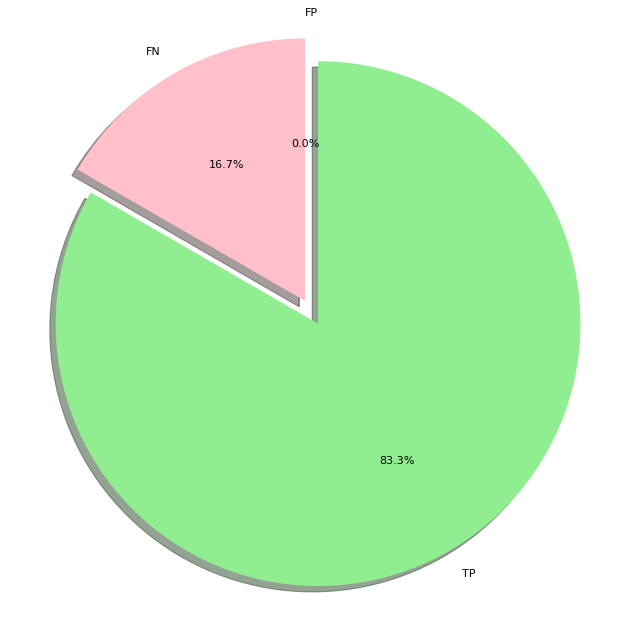

In [38]:
VIDEO_IDX = 0
video_url = list(result_dict.keys())[VIDEO_IDX]
print(video_url)
result_df = result_dict[video_url]
pretty_display(result_df)
pprint(get_classification_metrics(result_df))
draw_piechart(result_df)

gs://aliz_action_recognition_poc/trunc_video/MxtuVgTAgnhtsDaqVF1.mp4


,true_label,pred,confidence,label
1,nan,167.000000,0.998606,false positive
45,nan,732.000000,0.998630,false positive
49,916.000000,915.000000,0.999946,true positive
51,957.000000,956.000000,0.999527,true positive
52,984.000000,984.000000,0.999933,true positive
54,1038.000000,1037.000000,0.999863,true positive
55,1062.000000,1061.000000,0.999892,true positive
56,1137.000000,1136.000000,0.999976,true positive
57,1159.000000,1158.000000,0.999943,true positive
58,1176.000000,1176.000000,0.999918,true positive


{'false_negative': 0,
 'false_positive': 2,
 'precision': 0.92,
 'pred_positive': 25,
 'real_positive': 23,
 'recall': 1.0,
 'true_positive': 23}


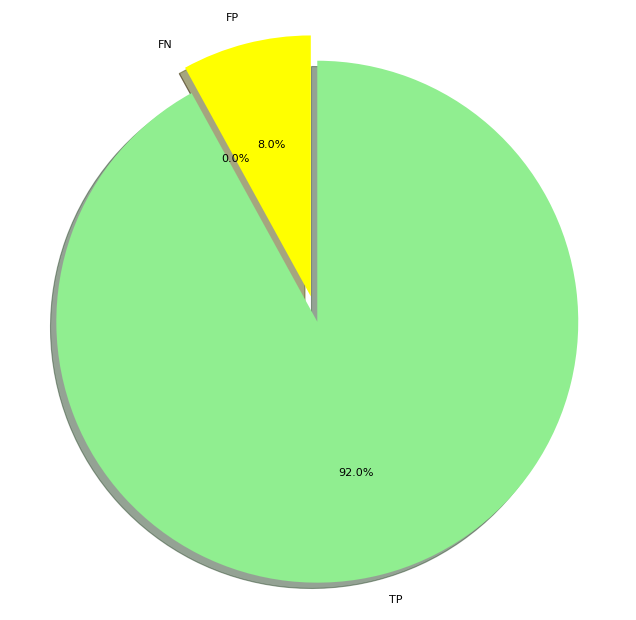

In [39]:
VIDEO_IDX = 1
video_url = list(result_dict.keys())[VIDEO_IDX]
print(video_url)
result_df = result_dict[video_url]
pretty_display(result_df)
pprint(get_classification_metrics(result_df))
draw_piechart(result_df)

gs://aliz_action_recognition_poc/trunc_video/Havoc_14_1_vs_RVA_14_Black_2022-01-09.mp4


,true_label,pred,confidence,label
31,604.000000,602.000000,0.999824,true positive
33,646.000000,644.000000,0.999971,true positive
34,679.000000,678.000000,0.999937,true positive
35,714.000000,714.000000,0.999775,true positive
36,736.000000,734.000000,0.999972,true positive
37,771.000000,769.000000,0.999937,true positive
38,794.000000,792.000000,0.999925,true positive
39,828.000000,826.000000,0.999875,true positive
40,856.000000,855.000000,0.999881,true positive
41,893.000000,891.000000,0.999896,true positive


{'false_negative': 0,
 'false_positive': 0,
 'precision': 1.0,
 'pred_positive': 20,
 'real_positive': 20,
 'recall': 1.0,
 'true_positive': 20}


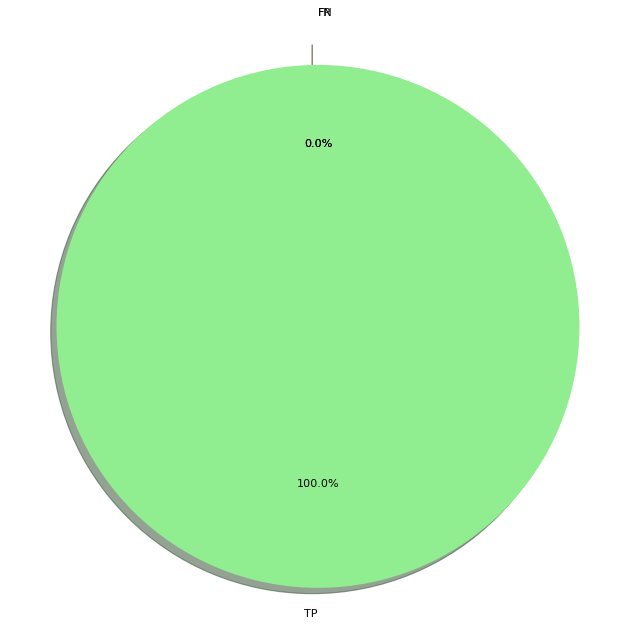

In [40]:
VIDEO_IDX = 2
video_url = list(result_dict.keys())[VIDEO_IDX]
print(video_url)
result_df = result_dict[video_url]
pretty_display(result_df)
pprint(get_classification_metrics(result_df))
draw_piechart(result_df)

gs://aliz_action_recognition_poc/trunc_video/RVA_15_Elite_v_Saddleback_15.mp4


,true_label,pred,confidence,label
51,590.000000,589.000000,0.999906,true positive
52,610.000000,609.000000,0.999929,true positive
54,635.000000,632.000000,0.999987,true positive
55,653.000000,650.000000,0.999702,true positive
56,665.000000,662.000000,0.998402,true positive
57,684.000000,682.000000,0.999885,true positive
58,702.000000,703.000000,0.999536,true positive
59,730.000000,728.000000,0.999954,true positive
60,750.000000,748.000000,0.999970,true positive
61,773.000000,771.000000,0.999822,true positive


{'false_negative': 0,
 'false_positive': 0,
 'precision': 1.0,
 'pred_positive': 69,
 'real_positive': 69,
 'recall': 1.0,
 'true_positive': 69}


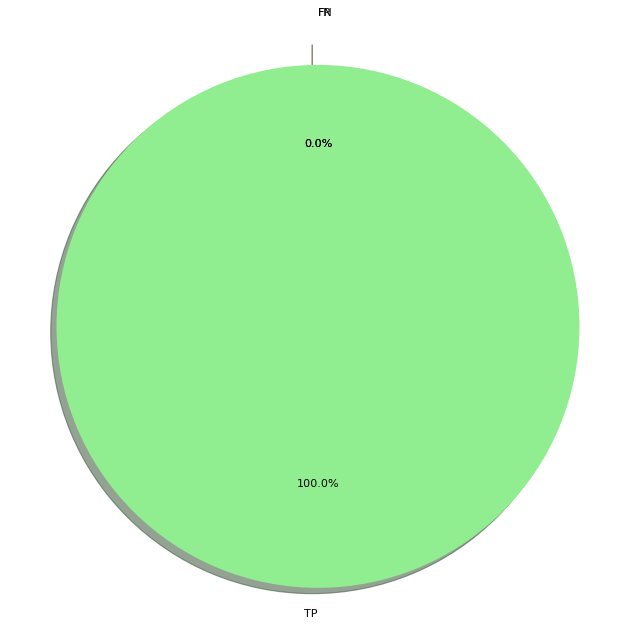

In [41]:
VIDEO_IDX = 3
video_url = list(result_dict.keys())[VIDEO_IDX]
print(video_url)
result_df = result_dict[video_url]
pretty_display(result_df)
pprint(get_classification_metrics(result_df))
draw_piechart(result_df)

gs://aliz_action_recognition_poc/trunc_video/Aspire_18_Premier_vs_OK_Charge_18_UA_2022-02-18.mp4


,true_label,pred,confidence,label
10,679.000000,678.000000,0.999871,true positive
11,726.000000,724.000000,0.999876,true positive
13,759.000000,759.000000,0.998433,true positive
15,812.000000,810.000000,0.999714,true positive
16,832.000000,831.000000,0.999524,true positive
17,854.000000,853.000000,0.999933,true positive
19,880.000000,878.000000,0.999935,true positive
20,901.000000,901.000000,0.999532,true positive
21,1193.000000,1193.000000,0.999428,true positive
22,1215.000000,1216.000000,0.998944,true positive


{'false_negative': 0,
 'false_positive': 1,
 'precision': 0.9444444444444444,
 'pred_positive': 18,
 'real_positive': 17,
 'recall': 1.0,
 'true_positive': 17}


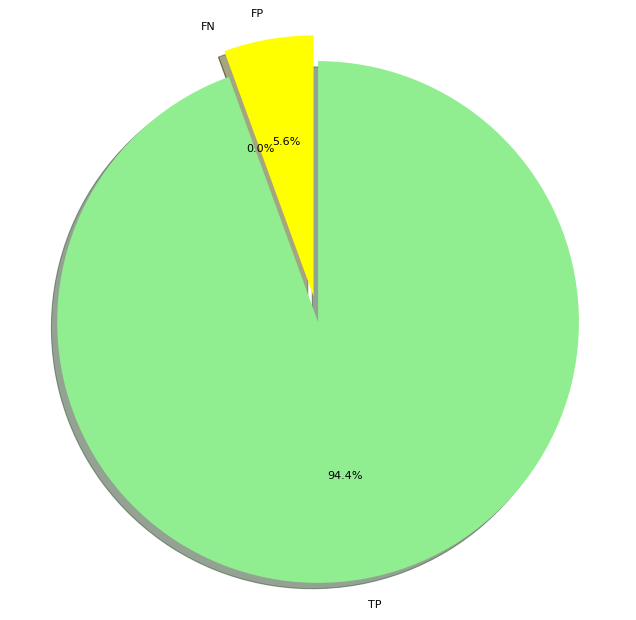

In [42]:
VIDEO_IDX = 4
video_url = list(result_dict.keys())[VIDEO_IDX]
print(video_url)
result_df = result_dict[video_url]
pretty_display(result_df)
pprint(get_classification_metrics(result_df))
draw_piechart(result_df)